# **Modeling and Evaluation**

## Objectives

#### Business requirement

  - The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

#### Outputs

- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices to change prediction inference in labels
- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file


### Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Set working directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-cherry-leaves_milestonePP5/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir=os.getcwd()
work_dir

'/workspace/mildew-detection-cherry-leaves_milestonePP5'

### Import packages

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Setting Input directories

In [7]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Setting Output directory




In [8]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Setting labels

In [9]:
labels = os.listdir(train_path)
print(f'Image labels are: {labels}')

Image labels are: ['healthy', 'powdery_mildew']


### Set Image shapes

In [10]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## **Number of images in train, test and validation datasets**

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




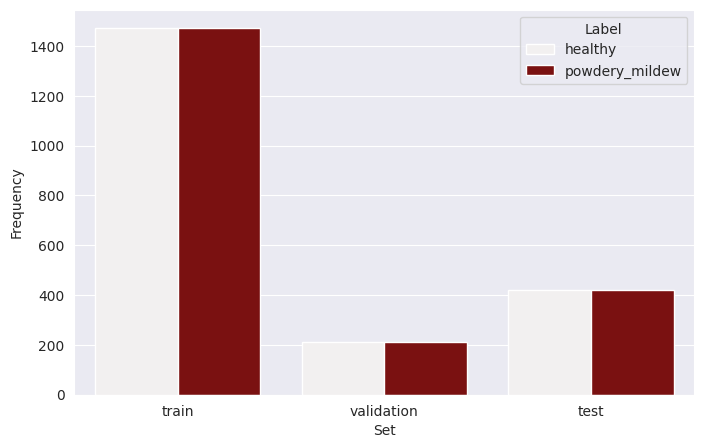

In [11]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', color='darkred')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## **Image augmentation**

### Image data generator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator




In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Augment training image dataset

In [14]:
# Set batch size
batch_size = 20 
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset


In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### **Plot augmented training image**



(20, 256, 256, 3)


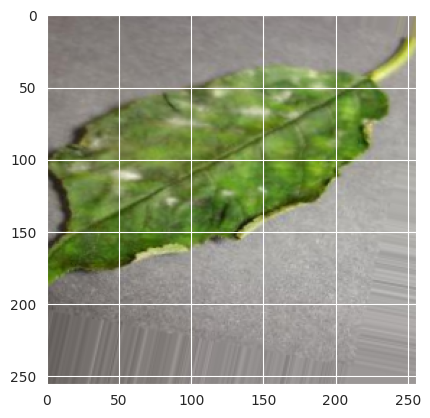

(20, 256, 256, 3)


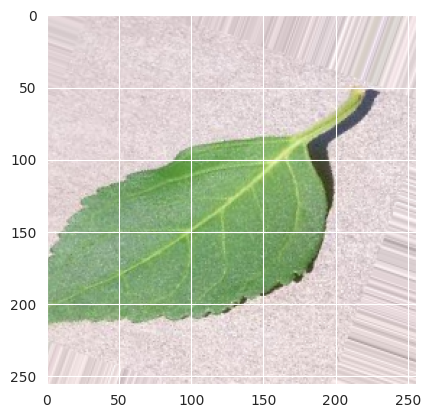

(20, 256, 256, 3)


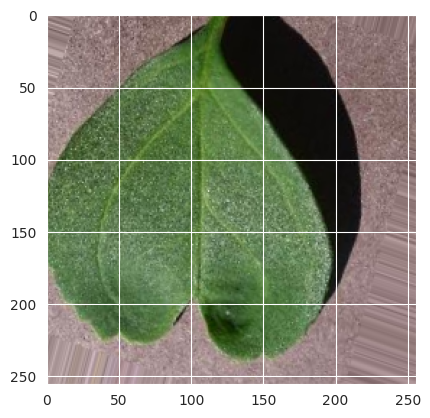

In [17]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   
    plt.imshow(img[0])
    plt.show()

### **Plot augmented validation and test set images**


(20, 256, 256, 3)


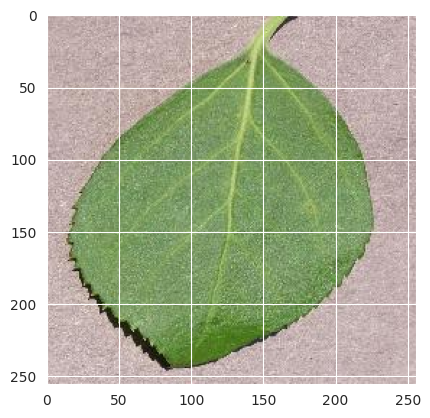

(20, 256, 256, 3)


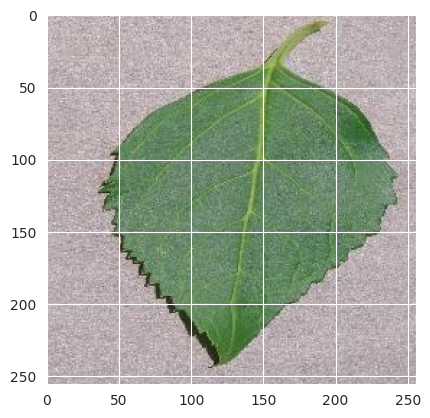

(20, 256, 256, 3)


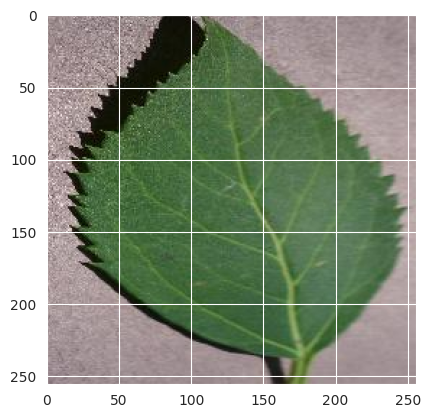

In [18]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


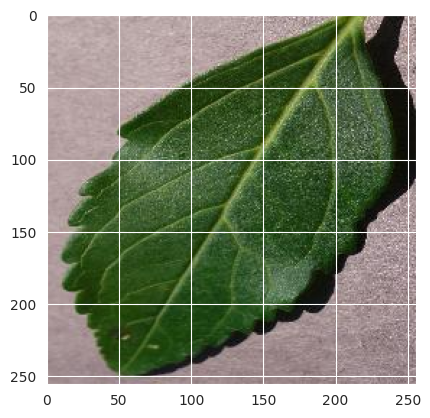

(20, 256, 256, 3)


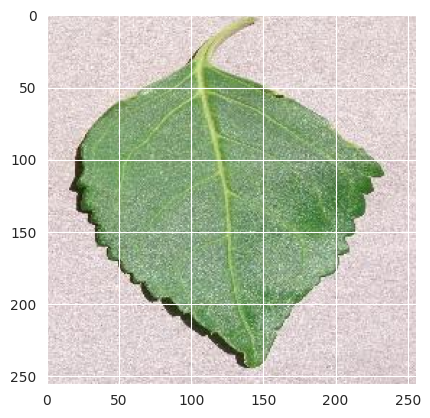

(20, 256, 256, 3)


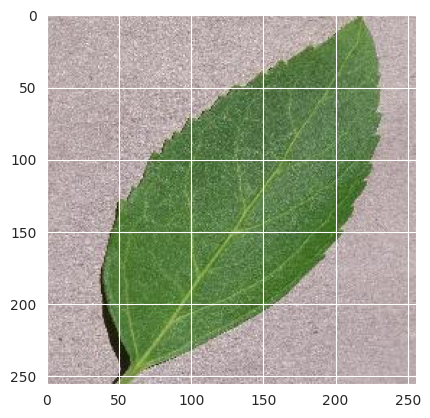

In [19]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

 ### Save class indices




In [20]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

### **Model Creation**

#### Import model packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

#### Model

In [22]:
def image_tf_model():
    """
 Model creation with different layers and optimizers, different filters, diffrent 
 number of layers and optimizers.
 """

 

    model = Sequential()
 ### input layer
    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=12, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    ### output
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model
 
    
   

#### Model summary

In [23]:
image_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 12)      3468      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 8)         872       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0

2023-02-12 19:22:57.204469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:

early_stop = EarlyStopping(monitor='val_loss',patience=3)

#### **Fit Model for Model training**

In [25]:
model = image_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-02-12 19:23:05.501305: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 96s 645ms/step - loss: 0.4170 - accuracy: 0.7948 - val_loss: 0.0771 - val_accuracy: 0.9738
Epoch 2/25
147/147 [==============================] - 95s 644ms/step - loss: 0.1309 - accuracy: 0.9480 - val_loss: 0.0530 - val_accuracy: 0.9952
Epoch 3/25
147/147 [==============================] - 95s 643ms/step - loss: 0.0805 - accuracy: 0.9744 - val_loss: 0.0141 - val_accuracy: 0.9976
Epoch 4/25
147/147 [==============================] - 94s 641ms/step - loss: 0.0720 - accuracy: 0.9757 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/25
147/147 [==============================] - 110s 749ms/step - loss: 0.0352 - accuracy: 0.9880 - val_loss: 6.1557e-04 - val_accuracy: 1.0000
Epoch 6/25
147/147 [==============================] - 128s 870ms/step - loss: 0.0332 - accuracy: 0.9911 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/25
147/147 [==============================] - 102s 693ms/step - loss: 0.0311 - accuracy: 0.9915 - val_loss: 7.4550e-

#### Save Model

In [26]:
model.save("outputs/v1/trainings/train-9/powdery_mildew_detector.h5")

---

#### **Evaluate Model Performance**

### Model learning curve

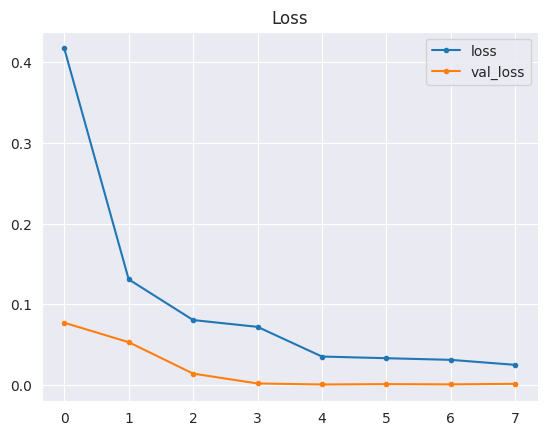

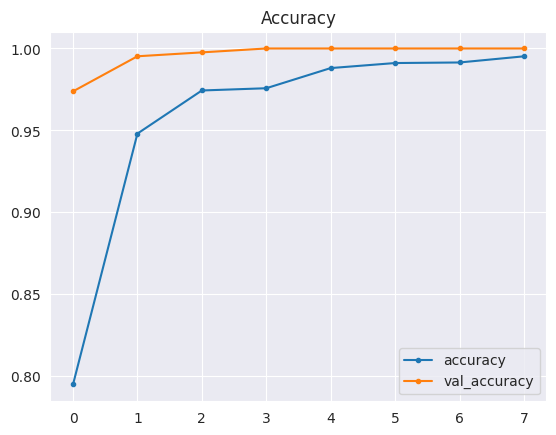

In [27]:
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()


print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()




## Model Evaluation

#### Load saved model


In [29]:
from keras.models import load_model
model = load_model("outputs/v1/trainings/train-9/powdery_mildew_detector.h5")

#### Evaluate model on test set

In [30]:
evaluation = model.evaluate(test_set)


43/43 [==============================] - 10s 225ms/step - loss: 0.0032 - accuracy: 1.0000


#### Save evaluation pickle

In [31]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

#### **Predict new images**


Load image as PIL

Image shape: (256, 256), Image mode: RGB


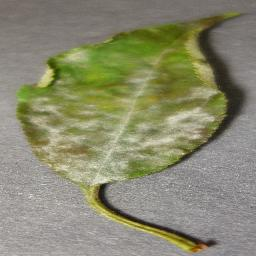

In [32]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[1] # select healthy or Powdery Mildew

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to an array to make prediction

In [33]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [34]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999999
powdery_mildew
